In [1]:
import h5py
import numpy as np
import os
import mediapy as media
import cv2
import tqdm
import matplotlib.pyplot as plt

(780, 1400)


""

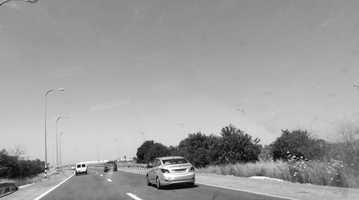

In [2]:
# Converts image to grayscale and displays it
img = cv2.imread("9.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.GaussianBlur(img,(15,15),0)

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255
print(img_gray.shape)
# media.show_image(img_rgb, height=200)
media.show_image(img_gray, height=200)


grayscale image,gradient magnitude,highlight mask,shadow mask

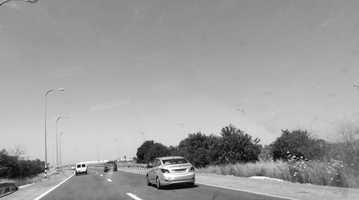
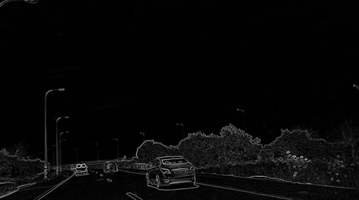
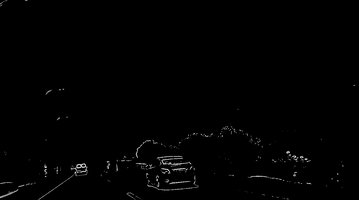
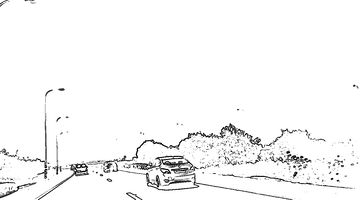

(6556,)
[ 0.         -1.82969721 -1.80871426 -0.53665704 -1.77510815 -1.78828464
 -1.77030382 -1.74692697 -1.74663465 -1.7885209  -1.84231548 -1.85983645
 -1.8516553  -1.83870675 -1.79852392 -1.50361435 -1.74699445 -1.77236738
 -1.76300123 -1.75191131 -1.74360395 -1.73226395 -1.72396953 -1.90768291
 -1.92615517 -1.90941052 -1.9031767  -1.88160127 -2.00141405 -2.03592354
 -1.97901456 -1.94883199 -2.18509385 -2.08485749 -2.14234885 -2.12660527
 -2.07819099 -2.1733921  -2.14886654 -2.17946312 -2.16766133 -2.16046931
 -2.23180371 -2.17708751 -2.25158727 -2.24455036 -2.16595759 -2.23260087
 -2.21743413 -1.57079633]


In [3]:
# Performs Sobel edge detection on image
# Calculates edge gradients / magnitudes
# Finds highlights and shadows

sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=5)

# Compute gradient magnitude and direction
gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
gradient_direction = np.arctan2(sobely, sobelx)

gradient_direction_vectors = np.stack([np.cos(gradient_direction), np.sin(gradient_direction)], axis=-1)

# Use threshold to find highlight and shadow
min_gm = np.min(gradient_magnitude)
max_gm = np.max(gradient_magnitude)
diff = max_gm - min_gm
high_threshold = min_gm + diff * 0.40  # adjusted for this image
low_threshold = min_gm + diff * 0.20   # adjusted for this image

# Highlight area
highlight_mask = gradient_magnitude > high_threshold
highlight_directions = gradient_direction[highlight_mask]
highlight_coords = np.column_stack(np.where(highlight_mask))

# Shadow area
shadow_mask = gradient_magnitude < low_threshold
shadow_directions = gradient_direction[shadow_mask]

# Convert masks to uint8 for display
highlight_mask_display = (highlight_mask.astype(np.uint8) * 255)
shadow_mask_display = (shadow_mask.astype(np.uint8) * 255)

# Convert the grayscale image back to uint8 for display
img_gray_display = (img_gray * 255).astype(np.uint8)

# Normalize gradient magnitude for display
gradient_magnitude_display = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Display the results
images = {
'grayscale image': img_gray_display,
'gradient magnitude': gradient_magnitude_display,
'highlight mask': highlight_mask_display,
'shadow mask': shadow_mask_display,
}

media.show_images(images, border=True, height=200)

# cv2.imshow('Grayscale Image', img_gray_display)
# cv2.imshow('Gradient Magnitude', gradient_magnitude_display)
# cv2.imshow('Highlights', highlight_mask_display)
# cv2.imshow('Shadows', shadow_mask_display)

# # Wait for a key press to close the window
# cv2.waitKey(0)
# cv2.destroyAllWindows()


print((highlight_directions.shape))
print(highlight_directions[0:50])

[ 0.99326113 -0.11589791]
[0.93895204 0.34404805]
[-0.11589791 -0.99326113]
[0.11589791 0.99326113]
[ 0.34404805 -0.93895204]
[-0.34404805  0.93895204]


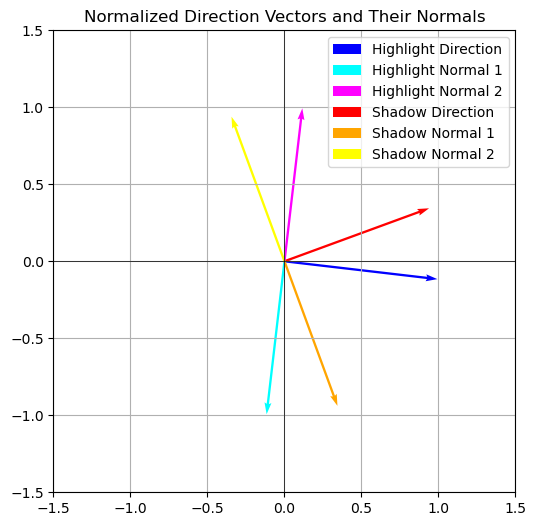

""

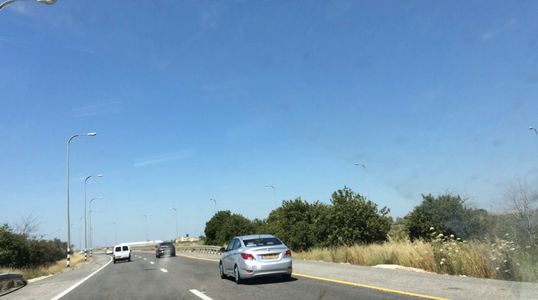

In [4]:
# average highlight and shadow directions as angles
avg_highlight_direction_angle = np.mean(highlight_directions)
avg_shadow_direction_angle = np.mean(shadow_directions)

avg_highlight_direction = np.array([np.cos(avg_highlight_direction_angle), np.sin(avg_highlight_direction_angle)])
avg_shadow_direction = np.array([np.cos(avg_shadow_direction_angle), np.sin(avg_shadow_direction_angle)])

print(avg_highlight_direction)
print(avg_shadow_direction)

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

highlight_direction_normalized = normalize(avg_highlight_direction)
shadow_direction_normalized = normalize(avg_shadow_direction)

highlight_normal_1 = np.array([highlight_direction_normalized[1], -highlight_direction_normalized[0]])
highlight_normal_2 = np.array([-highlight_direction_normalized[1], highlight_direction_normalized[0]])

shadow_normal_1 = np.array([shadow_direction_normalized[1], -shadow_direction_normalized[0]])
shadow_normal_2 = np.array([-shadow_direction_normalized[1], shadow_direction_normalized[0]])

print(highlight_normal_1)
print(highlight_normal_2)
print(shadow_normal_1)
print(shadow_normal_2)

# Plotting
plt.figure(figsize=(6, 6))
origin = [0, 0]

# Plot highlight direction and its normals
plt.quiver(*origin, *highlight_direction_normalized, color='blue', angles='xy', scale_units='xy', scale=1, label='Highlight Direction', width=0.005)
plt.quiver(*origin, *highlight_normal_1, color='cyan', angles='xy', scale_units='xy', scale=1, label='Highlight Normal 1', width=0.005)
plt.quiver(*origin, *highlight_normal_2, color='magenta', angles='xy', scale_units='xy', scale=1, label='Highlight Normal 2', width=0.005)

# Plot shadow direction and its normals
plt.quiver(*origin, *shadow_direction_normalized, color='red', angles='xy', scale_units='xy', scale=1, label='Shadow Direction', width=0.005)
plt.quiver(*origin, *shadow_normal_1, color='orange', angles='xy', scale_units='xy', scale=1, label='Shadow Normal 1', width=0.005)
plt.quiver(*origin, *shadow_normal_2, color='yellow', angles='xy', scale_units='xy', scale=1, label='Shadow Normal 2', width=0.005)

# Set plot limits and labels
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

plt.legend()
plt.title('Normalized Direction Vectors and Their Normals')
plt.show()

media.show_image(img, height=300)

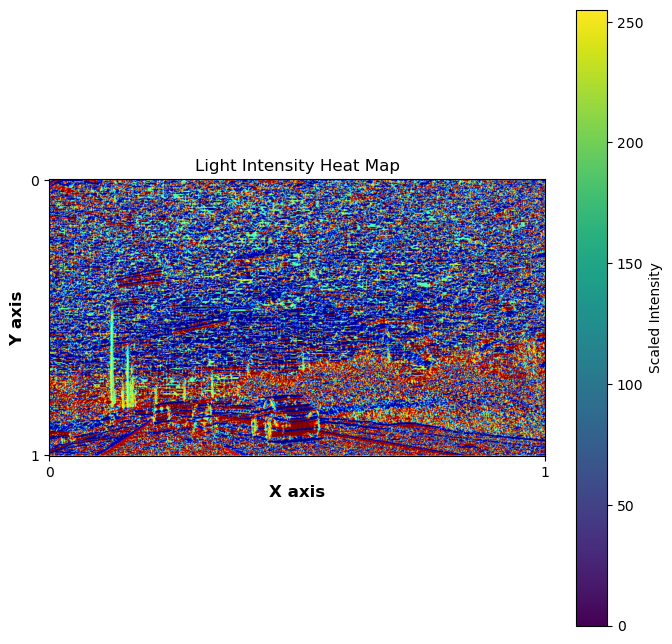

In [5]:
# Calculate light intensity based on dot product with normal vector
light_intensity = np.sum(gradient_direction_vectors * highlight_normal_2, axis=-1)

# Normalize light intensity to the range [0, 1]
light_intensity_normalized = (light_intensity - np.min(light_intensity)) / (np.max(light_intensity) - np.min(light_intensity))

# Apply Gaussian blur to smooth the heat map
light_intensity_smooth = cv2.GaussianBlur(light_intensity_normalized, (15, 15), 0)

# Optionally resize the intensity map to a specific dimension
# light_intensity_resized = cv2.resize(light_intensity_normalized, (128, 128))

# Generate heat map
heat_map = cv2.applyColorMap((light_intensity_normalized * 255).astype(np.uint8), cv2.COLORMAP_JET)

# Display the heat map
plt.figure(figsize=(8, 8))
plt.imshow(heat_map)
plt.colorbar(label="Scaled Intensity")
plt.xlabel("X axis", fontsize=12, fontweight='bold')
plt.ylabel("Y axis", fontsize=12, fontweight='bold')
plt.xticks([0, heat_map.shape[1] - 1], [0, 1])
plt.yticks([0, heat_map.shape[0] - 1], [0, 1])
plt.title("Light Intensity Heat Map")
plt.show()

In [5]:
# Calculate light intensity based on dot product with normal vector
light_intensity = np.sum(gradient_direction_vectors * highlight_normal_2, axis=-1)

# Normalize light intensity to the range [0, 1]
light_intensity = (light_intensity - np.min(light_intensity)) / (np.max(light_intensity) - np.min(light_intensity))

light_intensity_smooth = cv2.GaussianBlur(light_intensity_normalized, (75, 75), 0)

intensity_map_display = cv2.normalize(light_intensity, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
img_gray_display = (img_gray * 255).astype(np.uint8)

# Display the results
images = {
    'grayscale image': img_gray_display,
    'intensity map': intensity_map_display,
}

plt.figure(figsize=(8, 8))
for i, (title, img) in enumerate(images.items()):
    plt.subplot(1, len(images), i + 1)
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

NameError: name 'light_intensity_normalized' is not defined

Number of highlights: 6556
Highlight coordinates (sample): [[  0  97]
 [  1  26]
 [  1  27]
 [  1  97]
 [  1 100]]
Highlight directions (sample): [ 0.         -1.82969721 -1.80871426 -0.53665704 -1.77510815]
Sample highlight normals: [[-0.          1.        ]
 [ 0.96667196 -0.25601822]
 [ 0.97183078 -0.23567972]
 [ 0.51126584  0.85942262]
 [ 0.97920084 -0.20289335]]


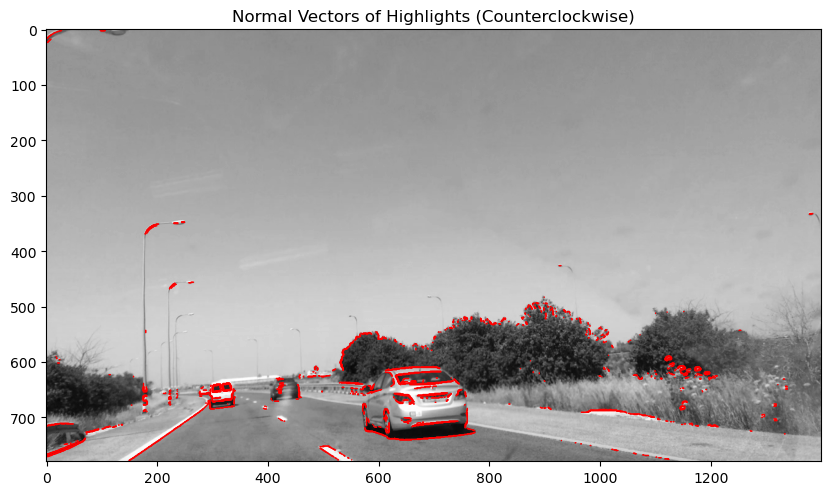

In [7]:
# Calculate normals to all highlight direction vectors in image
# Plot a vector map of all normals
# Identify convergence point of all those vectors == light source
# Cannot be with normalized vectors 


def compute_normals_from_angles(angles):
    """
    Compute the normal vectors for an array of direction angles.
    
    Parameters:
    angles (np.ndarray): Array of angles in radians.

    Returns:
    np.ndarray: Array of shape (N, 2) where each row represents the normal vector.
    """
    # Convert angles to direction vectors
    direction_vectors = np.stack([np.cos(angles), np.sin(angles)], axis=-1)
    
    # Compute normal vectors (rotated counterclockwise)
    normals = np.zeros_like(direction_vectors)
    normals[:, 0] = -direction_vectors[:, 1]
    normals[:, 1] = direction_vectors[:, 0]
    
    return normals

# Debugging print statements
print(f"Number of highlights: {len(highlight_coords)}")
print(f"Highlight coordinates (sample): {highlight_coords[:5]}")
print(f"Highlight directions (sample): {highlight_directions[:5]}")

# Compute normals
highlight_normals = compute_normals_from_angles(highlight_directions)
print("Sample highlight normals:", highlight_normals[:5])


# Plotting
plt.figure(figsize=(10, 10))
plt.imshow(img_gray, cmap='gray')

# Plot the normal vectors
for coord, normal in zip(highlight_coords, highlight_normals):
    y, x = coord
    coord = [x, y]
    scale = 0
    angle = [scale*normal[0], scale*normal[1]]
    plt.quiver(*coord, *angle, color='red', angles='xy', scale_units='xy', scale=1, width=0.002)

plt.title('Normal Vectors of Highlights (Counterclockwise)')
# plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.show()


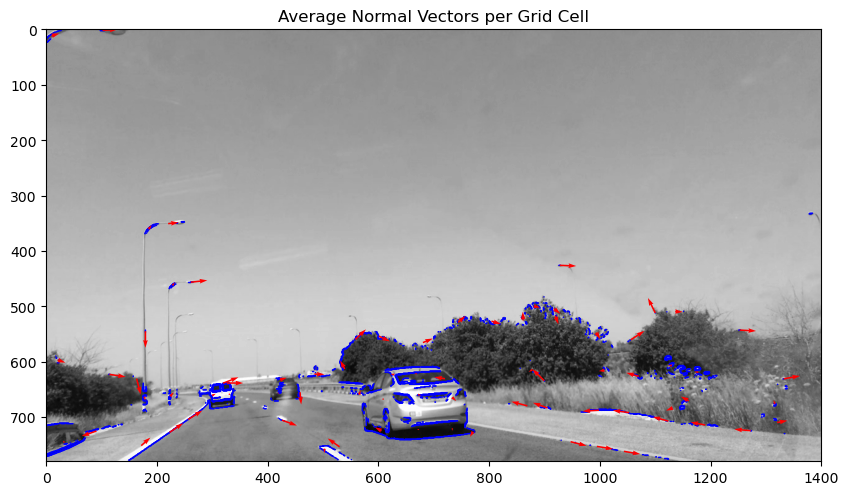

In [8]:
# Test Vector Graphs

# image_width, image_height = img.width, img.height

# # Example normal vectors and coordinates
# coords = np.array([[64, 64], [32, 32], [96, 96]])  # Example coordinates
# normals = np.array([[10, -10], [-10, 10], [10, 10]])  # Example normal vectors

# # Plotting
# plt.figure(figsize=(10, 10))
# plt.imshow(img_gray, cmap='gray')

# # Plot the normal vectors
# scaling_factor = 50  # Change this factor to see the effect
# for coord, normal in zip(coords, normals):
#     y, x = coord
#     plt.quiver(x, y, normal[0], normal[1], color='red', angles='xy', scale_units='xy', scale=1, width=0.002)

# plt.title('Normal Vectors of Highlights (Counterclockwise)')
# plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
# plt.xlim(0, image_width)
# plt.ylim(image_height, 0)  # Inverted for correct display
# plt.show()


def average_vectors_per_grid(coords, normals, grid_size, image_shape):
    """
    Compute the average normal vector per grid cell.

    Parameters:
    coords (np.ndarray): Array of coordinates.
    normals (np.ndarray): Array of normal vectors.
    grid_size (int): Size of each grid cell (both width and height).
    image_shape (tuple): Shape of the image (height, width).

    Returns:
    tuple: (average_coords, average_normals)
    """
    height, width = image_shape
    num_rows = height // grid_size
    num_cols = width // grid_size

    average_coords = []
    average_normals = []

    for i in range(num_rows):
        for j in range(num_cols):
            # Define grid boundaries
            y_min = i * grid_size
            y_max = (i + 1) * grid_size
            x_min = j * grid_size
            x_max = (j + 1) * grid_size

            # Find vectors within this grid cell
            in_cell = (coords[:, 0] >= y_min) & (coords[:, 0] < y_max) & \
                      (coords[:, 1] >= x_min) & (coords[:, 1] < x_max)
            
            if np.any(in_cell):
                cell_coords = coords[in_cell]
                cell_normals = normals[in_cell]
                average_coord = np.mean(cell_coords, axis=0)
                average_normal = np.mean(cell_normals, axis=0)
                average_coords.append(average_coord)
                average_normals.append(average_normal)

    return np.array(average_coords), np.array(average_normals)

# Example usage
image_height, image_width = img.shape
# coords = np.array([[64, 64], [32, 32], [96, 96], [40, 50], [70, 80]])  # Example coordinates
# normals = np.array([[10, 10], [-10, 10], [10, 10], [6, -6], [8, -8]])  # Example normal vectors

grid_size = 64  # Size of grid cells
average_coords, average_normals = average_vectors_per_grid(highlight_coords, highlight_normals, grid_size, (image_height, image_width))

# Plotting
plt.figure(figsize=(10, 10))
plt.imshow(img_gray, cmap='gray') 

# Plot the normal vectors
scaling_factor = 1  # Change this factor to see the effect
for coord, normal in zip(highlight_coords, highlight_normals):
    y, x = coord
    plt.quiver(x, y, normal[0], normal[1], color='blue', angles='xy', scale_units='xy', scale=scaling_factor, width=0.002)


# Plot the average normal vectors
scaling_factor = 30  # Adjust this factor as needed
for coord, normal in zip(average_coords, average_normals):
    y, x = coord
    plt.quiver(x, y, scaling_factor*normal[0], scaling_factor*normal[1], color='red', angles='xy', scale_units='xy', scale=1, width=0.002)

plt.title('Average Normal Vectors per Grid Cell')
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.xlim(0, image_width)
plt.ylim(image_height, 0)  # Inverted for correct display
plt.show()

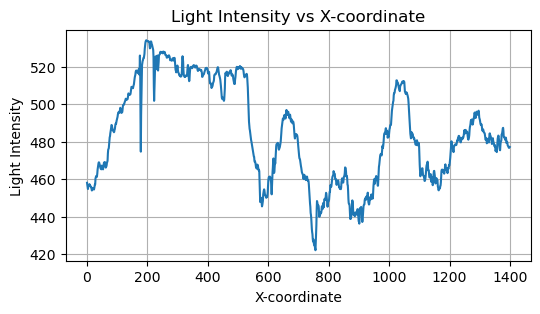

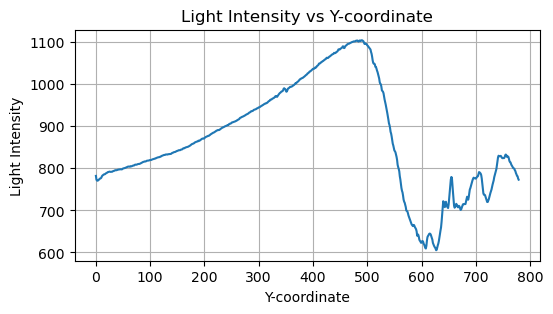

In [9]:
# Show change in light intensity vs pixel position
light_intensity = cv2.normalize(img_gray.astype('float32'), None, 0.0, 1.0, cv2.NORM_MINMAX)
intensity_sum_x = np.sum(light_intensity, axis=0)
intensity_sum_y = np.sum(light_intensity, axis=1)


# Plot intensity vs x-coordinate
plt.figure(figsize=(6, 3))
plt.plot(intensity_sum_x)
plt.title('Light Intensity vs X-coordinate')
plt.xlabel('X-coordinate')
plt.ylabel('Light Intensity')
plt.grid(True)
plt.show()

# Plot intensity vs y-coordinate
plt.figure(figsize=(6, 3))
plt.plot(intensity_sum_y)
plt.title('Light Intensity vs Y-coordinate')
plt.xlabel('Y-coordinate')
plt.ylabel('Light Intensity')
plt.grid(True)
plt.show()

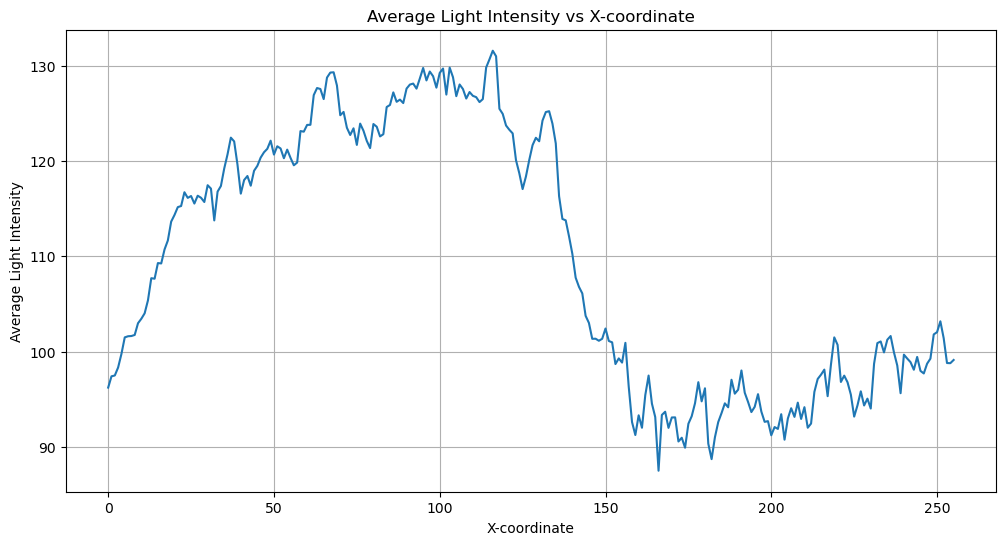

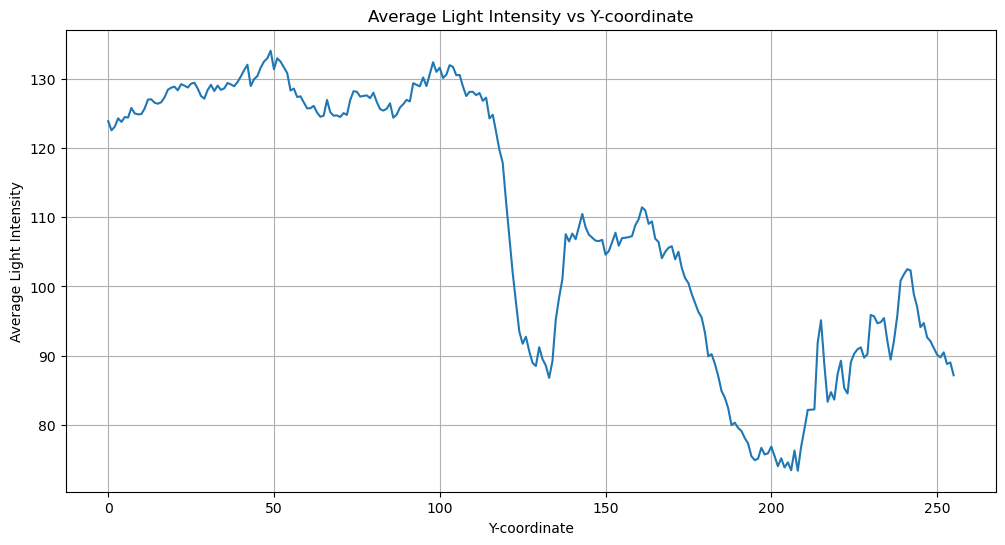

In [12]:
# Perform above computation across averaged light intensities from multiple photos

def load_and_resize_image(path, target_shape):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return cv2.resize(img, target_shape)

# Define the target shape for resizing (e.g., 128x128)

target_shape = (256, 256)

# Load and resize images
img1 = load_and_resize_image("9.png", target_shape)
img2 = load_and_resize_image("10.jpg", target_shape)
img3 = load_and_resize_image("11.jpg", target_shape)

# img1 = cv2.imread("9.png", cv2.IMREAD_GRAYSCALE)
# img2 = cv2.imread("10.jpg", cv2.IMREAD_GRAYSCALE)
# img3 = cv2.imread("11.jpg", cv2.IMREAD_GRAYSCALE)
num_imgs = 3

def normalize_image(img):
    return cv2.normalize(img.astype('float32'), None, 0.0, 1.0, cv2.NORM_MINMAX)

light_intensity1 = normalize_image(img1)
light_intensity2 = normalize_image(img2)
light_intensity3 = normalize_image(img3)

intensity_sum_x1 = np.sum(light_intensity1, axis=0)
intensity_sum_y1 = np.sum(light_intensity1, axis=1)

intensity_sum_x2 = np.sum(light_intensity2, axis=0)
intensity_sum_y2 = np.sum(light_intensity2, axis=1)

intensity_sum_x3 = np.sum(light_intensity3, axis=0)
intensity_sum_y3 = np.sum(light_intensity3, axis=1)

intensity_sum_x_avg = (intensity_sum_x1 + intensity_sum_x2 + intensity_sum_x3) / num_imgs
intensity_sum_y_avg = (intensity_sum_y1 + intensity_sum_y2 + intensity_sum_y3) / num_imgs

# Plot average intensity vs x-coordinate
plt.figure(figsize=(12, 6))
plt.plot(intensity_sum_x_avg)
plt.title('Average Light Intensity vs X-coordinate')
plt.xlabel('X-coordinate')
plt.ylabel('Average Light Intensity')
plt.grid(True)
plt.show()

# Plot average intensity vs y-coordinate
plt.figure(figsize=(12, 6))
plt.plot(intensity_sum_y_avg)
plt.title('Average Light Intensity vs Y-coordinate')
plt.xlabel('Y-coordinate')
plt.ylabel('Average Light Intensity')
plt.grid(True)
plt.show()



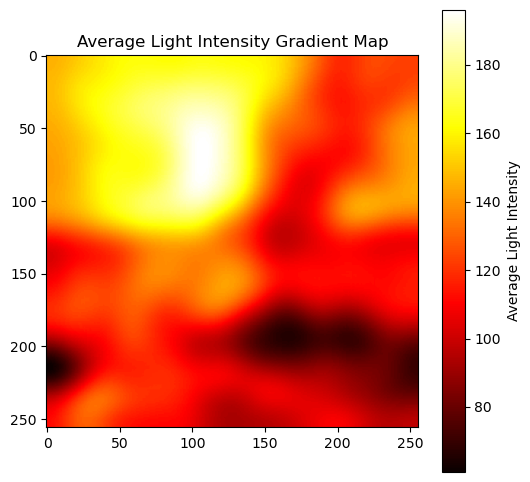

In [13]:
average_light_intensity = (light_intensity1 + light_intensity2 + light_intensity3) / 3

# Normalize the average light intensity map for display
average_light_intensity_display = cv2.normalize(average_light_intensity, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
avg_light_intensity_smooth = cv2.GaussianBlur(average_light_intensity_display, (75, 75), 0) 

# Plot the average light intensity gradient map
plt.figure(figsize=(6, 6))
plt.imshow(avg_light_intensity_smooth, cmap='hot')
plt.colorbar(label="Average Light Intensity")
plt.title('Average Light Intensity Gradient Map')
plt.show()

In [1]:
from sklearn.decomposition import PCA

def compute_gradients(img):
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    grad_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

def apply_pca(img):
    # Compute gradients
    sobel_x, sobel_y, grad_magnitude = compute_gradients(img)
    
    # Flatten the gradients
    gradient_vectors = np.stack([sobel_x.flatten(), sobel_y.flatten()], axis=1)
    
    # Apply PCA
    pca = PCA(n_components=2)
    pca.fit(gradient_vectors)
    
    return pca

def plot_pca_components(pca):
    plt.figure(figsize=(8, 8))
    
    # Plot PCA components
    plt.quiver([0], [0], [pca.components_[0, 0]], [pca.components_[0, 1]], angles='xy', scale_units='xy', scale=1, color='r', label='Principal Component 1')
    plt.quiver([0], [0], [pca.components_[1, 0]], [pca.components_[1, 1]], angles='xy', scale_units='xy', scale=1, color='b', label='Principal Component 2')
    
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.title('PCA of Gradient Vectors')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
pca = apply_pca(img)
plot_pca_components(pca)


NameError: name 'img' is not defined